In [77]:
#import library
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import random
import holidays

from sklearn.metrics import mean_absolute_error,mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

In [78]:
#import data
df=pd.read_csv(r"C:\Users\q\Desktop\Case\ds_exercise_data.csv",sep=",")

In [79]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 3 columns):
Date       1186 non-null datetime64[ns]
CashIn     1081 non-null float64
CashOut    1098 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 27.9 KB


To prepare data for Prophet

In [80]:
df_cash_in = df.rename(columns={'Date': 'ds', 'CashIn': 'y'})
df_cash_in = df_cash_in[["ds","y"]]
df_cash_in.tail()

,ds,y
1181,2019-03-27,45160.0
1182,2019-03-28,39480.0
1183,2019-03-29,70260.0
1184,2019-03-30,19250.0
1185,2019-03-31,46870.0


In [81]:
df_cash_out = df.rename(columns={'Date': 'ds', 'CashOut': 'y'})
df_cash_out = df_cash_out[["ds","y"]]
df_cash_out.head()

,ds,y
0,2016-01-01,6500.0
1,2016-01-02,23110.0
2,2016-01-03,7070.0
3,2016-01-04,18520.0
4,2016-01-05,22200.0


### Forecasting the CashIn for last 3 months to measure model performance
- First three years for train data.

In [82]:
model = Prophet()

In [83]:
#split first 3 years for training.
df_cash_in[:1096].tail()

,ds,y
1091,2018-12-27,42810.0
1092,2018-12-28,57660.0
1093,2018-12-29,NaN
1094,2018-12-30,31670.0
1095,2018-12-31,73460.0


In [84]:
#model fitting for training
model.fit(df_cash_in[:1096])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\q\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [85]:
#split the last 3 months for test
df_last_3_month_cash_in=df[1096:]["CashIn"]
df_last_3_month_cash_in

1096    27510.0
1097    58800.0
1098    57580.0
1099    39090.0
1100    57920.0
         ...   
1181    45160.0
1182    39480.0
1183    70260.0
1184    19250.0
1185    46870.0
Name: CashIn, Length: 90, dtype: float64

In [86]:
#using test data for predict
forecast = model.predict(df_cash_in[1096:])

          ds          yhat    yhat_lower    yhat_upper
0 2019-01-01  56149.189823  35933.013647  77194.775399
1 2019-01-02  58297.911759  37071.096010  79035.773637
2 2019-01-03  54791.491355  33195.782897  74681.968017
3 2019-01-04  53095.782245  32471.922108  74386.767017
4 2019-01-05  45095.135836  23740.911182  65498.507566


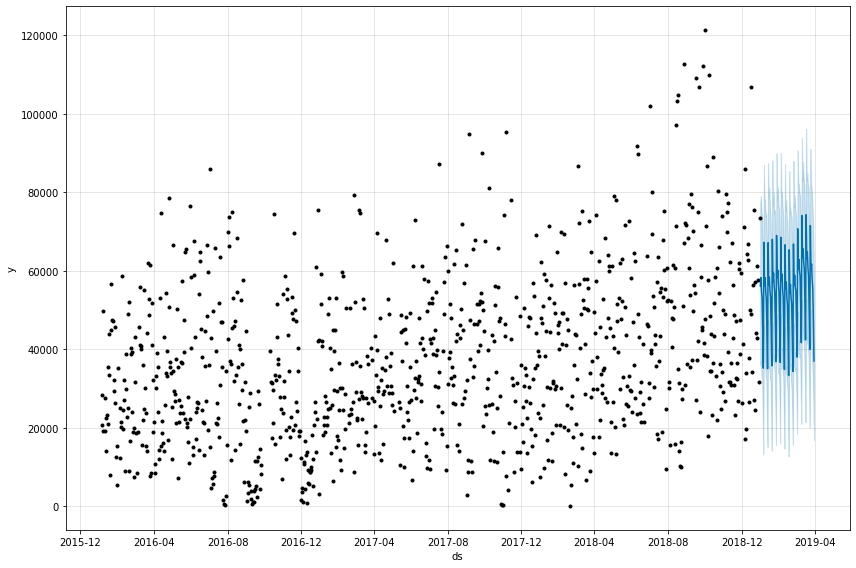

In [87]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast,figsize=(12,8))
plt.show()

Deep blue line is forecasting amount of money for cash out transactions, black dots are actually amount of money for cash out transactions. The light blue shade is 95% confidence interval around the forecast.

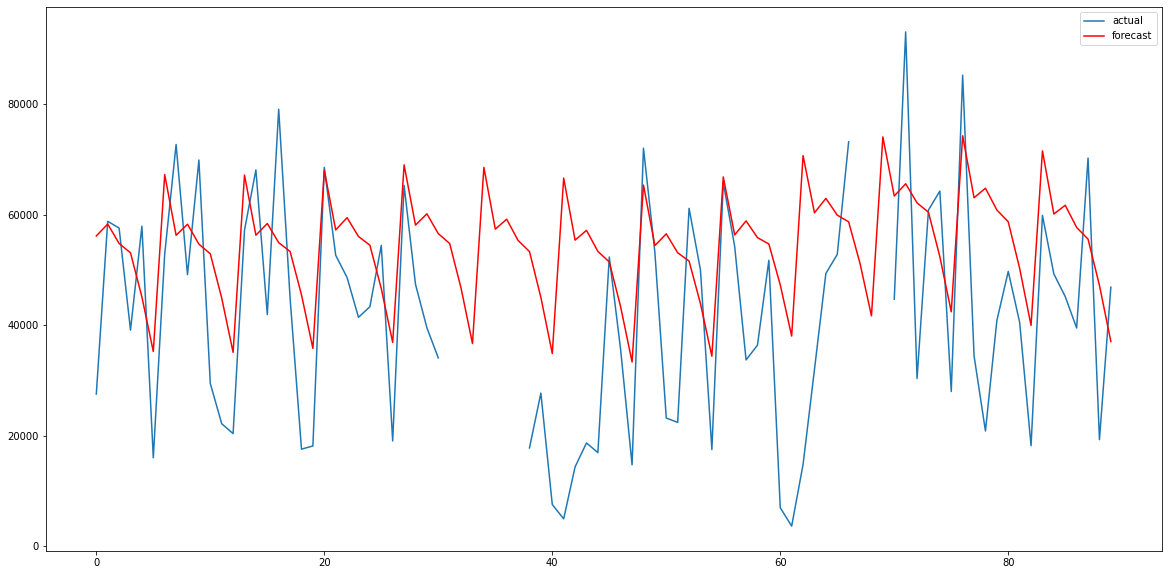

In [88]:
plt.figure(figsize=(20,10))
plt.plot(df_last_month_cash_in.reset_index()["CashIn"],label="actual")
plt.plot(forecast["yhat"],'r',label="forecast")
plt.legend()

In [89]:
df_cash_in[:1096].dropna(inplace=True)

C:\Users\q\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [90]:
y_true=df_last_month_cash_in.reset_index()[df_last_month_cash_in.reset_index()["CashIn"].notna()]["CashIn"].tolist()

In [91]:
y_pred = forecast.drop(index=[31, 32, 33, 34, 35, 36, 37, 67, 69])["yhat"].tolist() #Delete rows with nan values so that the lengths of y pred and y true values are equal

In [92]:
def mean_absolute_percentage_error(y_true, y_pred): #mape function
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [93]:
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE",mape)

MAPE 96.5787627183081


### Grid Search
Prophet Model Tuning

In [19]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 30


In [20]:
strt='2019-01-01'
end='2019-03-31'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    model2 =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         interval_width=0.95)
    model2.fit(df_cash_in[:1096])
    forecast = model2.predict(df_cash_in[1096:])
    forecast.head()
    y_true=df_last_month_cash_in.reset_index()[df_last_month_cash_in.reset_index()["CashIn"].notna()]["CashIn"].tolist()
    y_pred = forecast.drop(index=[31, 32, 33, 34, 35, 36, 37, 67, 69])["yhat"].tolist()
    
    MAPE = mean_absolute_percentage_error(y_true,y_pred)
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


C:\Users\q\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Mean Absolute Percentage Error(MAPE)------------------------------------ 88.57590186194932
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 102.08366780658518
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 90.4540503557056
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 102.45176010252261
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 91.58830210928488
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 103.69900605288326


In [21]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,62.133936,"{'changepoint_prior_scale': 0.5, 'n_changepoin..."
1,64.528511,"{'changepoint_prior_scale': 0.5, 'n_changepoin..."
2,64.844221,"{'changepoint_prior_scale': 0.5, 'n_changepoin..."
3,65.777337,"{'changepoint_prior_scale': 0.4, 'n_changepoin..."
4,66.603562,"{'changepoint_prior_scale': 0.4, 'n_changepoin..."


Out of total 30 models, we will select the parameters which has the least MAPE to train the final model and predict the next months amount of the money for cash in.

Best Parameters on which the model has the least MAPE is:

In [22]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.5,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [24]:
# Setup and final model with best parameters
final_model = Prophet(changepoint_prior_scale= 0.5,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.fit(df_cash_in)

In [25]:
future = final_model.make_future_dataframe(periods=30, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1209,2019-04-24,49339.125403,18841.391318,80760.738469
1210,2019-04-25,46022.505855,15679.282314,77648.209883
1211,2019-04-26,45196.346891,14807.541707,76726.841317
1212,2019-04-27,35206.569591,4444.828779,62805.083275
1213,2019-04-28,23118.069508,-10234.987627,53861.548870
1214,2019-04-29,61142.009245,29910.804177,90956.823992
1215,2019-04-30,47794.916445,15350.945045,78678.902822


Out of total 30 models, we will select the parameters which has the least MAPE to train the final model and predict the next months amount of the money for cash out.

Best Parameters on which the model has the least MAPE is:

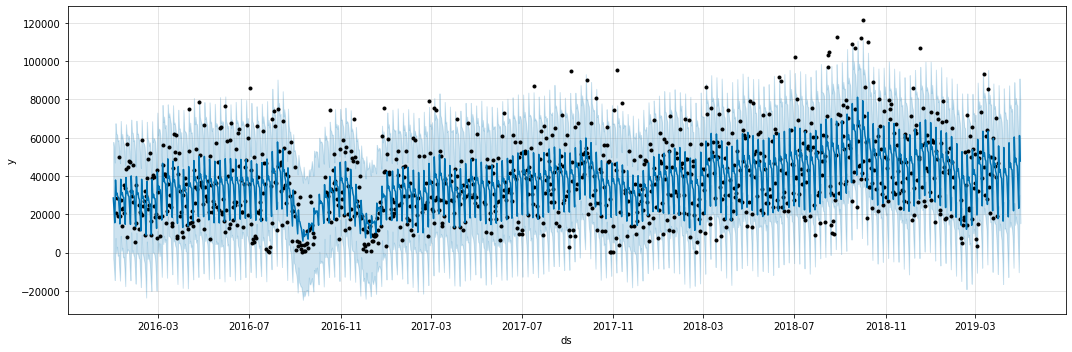

In [26]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [27]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-01,2361.549003,-2917.125424,57800.677474,2361.549003,2361.549003,9.788965,9.788965,9.788965,11.086409,...,0.281431,0.281431,0.281431,1.016014,1.016014,1.016014,0.0,0.0,0.0,28542.647401
1,2016-01-02,2376.775460,-8429.546052,55467.235530,2376.775460,2376.775460,9.788965,9.788965,9.788965,8.553350,...,-2.172460,-2.172460,-2.172460,0.936845,0.936845,0.936845,0.0,0.0,0.0,22706.167071
2,2016-01-03,2392.001917,-14335.281589,47064.620335,2392.001917,2392.001917,9.788965,9.788965,9.788965,5.518453,...,-5.125629,-5.125629,-5.125629,0.855118,0.855118,0.855118,0.0,0.0,0.0,15592.152357
3,2016-01-04,2407.228374,7646.836521,67590.894254,2407.228374,2407.228374,9.788965,9.788965,9.788965,14.748186,...,4.186833,4.186833,4.186833,0.772389,0.772389,0.772389,0.0,0.0,0.0,37909.479601
4,2016-01-05,2422.454831,-264.570732,62104.319482,2422.454831,2422.454831,9.788965,9.788965,9.788965,11.433716,...,0.954629,0.954629,0.954629,0.690122,0.690122,0.690122,0.0,0.0,0.0,30120.114473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,2019-04-26,4093.492565,14807.541707,76726.841317,3463.086467,4621.474652,9.788965,9.788965,9.788965,10.041023,...,0.281431,0.281431,0.281431,-0.029372,-0.029372,-0.029372,0.0,0.0,0.0,45196.346891
1212,2019-04-27,4092.303989,4444.828779,62805.083275,3427.570883,4650.887808,9.788965,9.788965,9.788965,7.603117,...,-2.172460,-2.172460,-2.172460,-0.013388,-0.013388,-0.013388,0.0,0.0,0.0,35206.569591
1213,2019-04-28,4091.115413,-10234.987627,53861.548870,3382.796279,4673.472858,9.788965,9.788965,9.788965,4.650799,...,-5.125629,-5.125629,-5.125629,-0.012537,-0.012537,-0.012537,0.0,0.0,0.0,23118.069508
1214,2019-04-29,4089.926837,29910.804177,90956.823992,3348.393315,4704.486875,9.788965,9.788965,9.788965,13.949414,...,4.186833,4.186833,4.186833,-0.026383,-0.026383,-0.026383,0.0,0.0,0.0,61142.009245
